# Breast Cancer Classification Models
This notebook trains and compares three models—CNN, Vision Transformer (ViT), and Swin Transformer—for binary classification on breast histology images, and evaluates them using various metrics.

In [9]:
import os
import warnings
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [10]:
# Suppress warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

## Data Loading and Preprocessing

In [11]:
train_dir = r"C:\Users\NITIN SINGH\Downloads\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\train"
val_dir = r"C:\Users\NITIN SINGH\Downloads\BreaKHis_v1\BreaKHis_v1\histology_slides\breast\validation"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, labels='inferred', label_mode='binary',
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, labels='inferred', label_mode='binary',
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=False)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 6327 files belonging to 2 classes.
Found 2383 files belonging to 2 classes.


## Model Definitions

### CNN

In [12]:
def create_cnn_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

### Vision Transformer (ViT)

In [13]:
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.projection = layers.Dense(embed_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return self.projection(patches)

def transformer_block(inputs, embed_dim, num_heads, ff_dim, dropout=0.1):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = layers.Add()([attention_output, inputs])
    y = layers.LayerNormalization(epsilon=1e-6)(x)
    y = layers.Dense(ff_dim, activation='relu')(y)
    y = layers.Dense(embed_dim)(y)
    return layers.Add()([x, y])

def create_vit_model(image_size, patch_size, embed_dim, num_heads, ff_dim, num_layers):
    inp = layers.Input(shape=image_size + (3,))
    x = PatchEmbedding(patch_size, embed_dim)(inp)
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, ff_dim)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

### Swin Transformer

In [14]:
class SwinTransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, window_size, shift_size=0, ff_dim=128, dropout=0.1):
        super(SwinTransformerBlock, self).__init__()
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim),
        ])
        self.dropout = layers.Dropout(dropout)
        self.window_size = window_size
        self.shift_size = shift_size

    def call(self, x):
        shortcut = x
        x_norm = self.norm1(x)
        B, H, W, C = tf.shape(x_norm)[0], tf.shape(x_norm)[1], tf.shape(x_norm)[2], tf.shape(x_norm)[3]
        x_flat = tf.reshape(x_norm, [B, H*W, C])
        attn_out = self.attn(x_flat, x_flat)
        attn_out = tf.reshape(attn_out, [B, H, W, C])
        x = shortcut + self.dropout(attn_out)
        x2 = self.norm2(x)
        ffn_out = self.ffn(x2)
        return x + self.dropout(ffn_out)

def create_swin_model(image_size, patch_size, embed_dim, window_size, num_blocks):
    inp = layers.Input(shape=image_size + (3,))
    x = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)(inp)
    for _ in range(num_blocks):
        x = SwinTransformerBlock(embed_dim, num_heads=4, window_size=window_size)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Model Training

In [15]:
input_shape = IMG_SIZE + (3,)
histories = {}

print("Training CNN...")
cnn_model = create_cnn_model(input_shape)
cnn_hist = cnn_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
histories['CNN'] = cnn_hist.history

print("Training ViT...")
vit_model = create_vit_model(IMG_SIZE, 16, 64, 4, 128, 4)
vit_hist = vit_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
histories['ViT'] = vit_hist.history

print("Training Swin...")
swin_model = create_swin_model(IMG_SIZE, 16, 64, 7, 4)
swin_hist = swin_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
histories['Swin'] = swin_hist.history

Training CNN...
Epoch 1/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 181s 453ms/step - accuracy: 0.7391 - loss: 0.5952 - val_accuracy: 0.6840 - val_loss: 0.5795
Epoch 2/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 101s 254ms/step - accuracy: 0.7722 - loss: 0.5124 - val_accuracy: 0.7272 - val_loss: 0.5774
Epoch 3/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 105s 263ms/step - accuracy: 0.8284 - loss: 0.4368 - val_accuracy: 0.8431 - val_loss: 0.3948
Epoch 4/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 183s 461ms/step - accuracy: 0.8426 - loss: 0.4092 - val_accuracy: 0.8582 - val_loss: 0.3740
Epoch 5/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 105s 264ms/step - accuracy: 0.8490 - loss: 0.4006 - val_accuracy: 0.8598 - val_loss: 0.3639
Epoch 6/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 346s 875ms/step - accuracy: 0.8523 - loss: 0.3837 - val_accuracy: 0.8531 - val_loss: 0.3760
Epoch 7/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 117s 293ms/step - accuracy: 0.8396 - loss: 0.4063 - val_accuracy: 0.6433 - val_loss: 0.7187
Epoch 8/10
396/396 ━━━━━━━━━━━━━━━━━━━━ 107s 270ms/step - ac

## Validation Accuracy Comparison

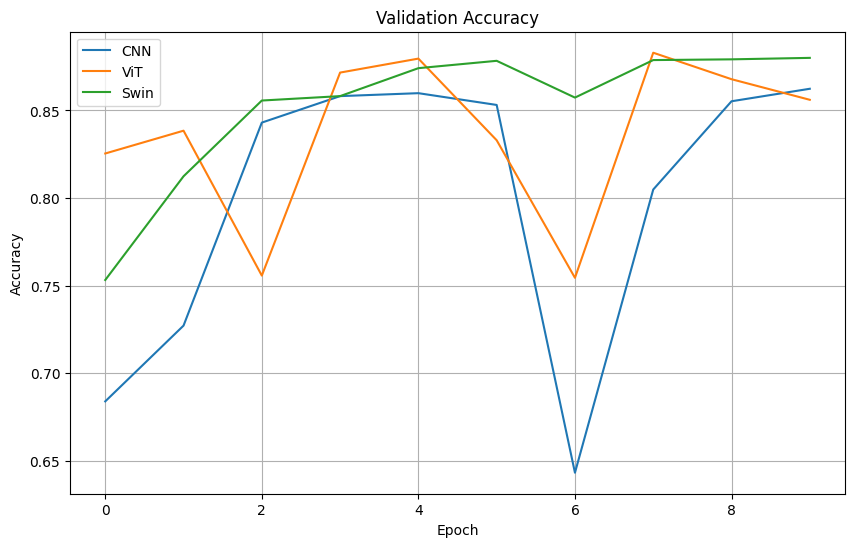

In [16]:
plt.figure(figsize=(10,6))
for name, h in histories.items():
    plt.plot(h['val_accuracy'], label=name)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Evaluation Metrics

In [18]:
# Gather ground truth and predictions
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

for name, model in [('CNN', cnn_model), ('ViT', vit_model), ('Swin', swin_model)]:
    print(f"### {name} Evaluation")
    # Predictions
    y_prob = model.predict(val_ds)
    y_pred = (y_prob > 0.5).astype(int)
    # Classification report
    print(classification_report(y_true, y_pred))
    # Confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    # ROC AUC
    auc = roc_auc_score(y_true, y_prob)
    print(f"ROC AUC: {auc:.4f}\n")

### CNN Evaluation
149/149 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step
              precision    recall  f1-score   support

         0.0       0.88      0.66      0.75       753
         1.0       0.86      0.96      0.90      1630

    accuracy                           0.86      2383
   macro avg       0.87      0.81      0.83      2383
weighted avg       0.86      0.86      0.86      2383

Confusion Matrix:
[[ 494  259]
 [  69 1561]]
ROC AUC: 0.8888

### ViT Evaluation
149/149 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72       753
         1.0       0.84      0.98      0.90      1630

    accuracy                           0.86      2383
   macro avg       0.89      0.78      0.81      2383
weighted avg       0.87      0.86      0.85      2383

Confusion Matrix:
[[ 439  314]
 [  29 1601]]
ROC AUC: 0.9281

### Swin Evaluation
149/149 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step
              precision    recall  f